# Final project
The Allen–Cahn equation (after John W. Cahn and Sam Allen) is a reaction–diffusion equation of mathematical physics which describes the process of phase separation in multi-component alloy systems, including order-disorder transitions.

The equation describes the time evolution of a scalar-valued state variable $\eta$  on a domain $\Omega=[0,1]$  during a time interval $[0,T]$, and is given (in one dimension) by:

$$
\frac{\partial \eta}{\partial t} - \varepsilon^2 \eta'' + f'(\eta) = 0, \qquad \eta'(0, t) = \eta'(1, t) = 0,\qquad\eta(x,0) = \eta_0(x)
$$

where $f$ is a double-well potential, $\eta_0$ is the initial condition, and $\varepsilon$ is the characteristic width of the phase transition.

This equation is the L2 gradient flow of the Ginzburg–Landau free energy functional, and it is closely related to the Cahn–Hilliard equation.

A typical example of double well potential is given by the following function

$$
f(\eta) = \eta^2(\eta-1)^2
$$

which has two minima in $0$ and $1$ (the two wells, where its value is zero), one local maximum in $0.5$, and it is always greater or equal than zero.

The two minima above behave like "attractors" for the phase $\eta$. Think of a solid-liquid phase transition (say water+ice) occupying the region $[0,1]$. When $\eta = 0$, then the material is liquid, while when $\eta = 1$ the material is solid (or viceversa).

Any other value for $\eta$ is *unstable*, and the equation will pull that region towards either $0$ or $1$.

Discretisation of this problem can be done by finite difference in time. For example, a fully explicity discretisation in time would lead to the following algorithm.

We split the interval $[0,T]$ in `n_steps` intervals, of dimension `dt = T/n_steps`. Given the solution at time `t[k] = k*dt`, it i possible to compute the next solution at time `t[k+1]` as

$$
\eta_{k+1} = \eta_{k} + \Delta t \varepsilon^2 \eta_k'' - \Delta t f'(\eta_k)
$$

Such a solution will not be stable. A possible remedy that improves the stability of the problem, is to treat the linear term $\Delta t \varepsilon^2 \eta_k''$ implicitly, and keep the term $-f'(\eta_k)$ explicit, that is:

$$
\eta_{k+1} - \Delta t \varepsilon^2 \eta_k'' = \eta_{k} - \Delta t f'(\eta_k)
$$

Grouping together the terms on the right hand side, this problem is identical to the one we solved in the python notebook number 9, with the exception of the constant $\Delta t \varepsilon^2$ in front the stiffness matrix.

In particular, given a set of basis functions $v_i$, representing $\eta = \eta^j v_j$ (sum is implied), we can solve the problem using finite elements by computing

$$
\big((v_i, v_j) + \Delta t \varepsilon^2  (v_i', v_j')\big) \eta^j_{k+1} = \big((v_i, v_j) \eta^j_{k} - \Delta t (v_i, f'(\eta_k))\big)
$$

where a sum is implied over $j$ on both the left hand side and the right hand side. Let us remark that while writing this last version of the equation we moved from a forward Euler scheme to a backward Euler scheme for the second spatial derivative term: that is, we used $\eta^j_{k+1}$ instead of $\eta^j_{k}$.  

This results in a linear system

$$
A x = b
$$

where 

$$
A_{ij} = M_{ij}+ \Delta t \varepsilon^2 K_{ij} = \big((v_i, v_j) + \Delta t \varepsilon^2  (v_i', v_j')\big) 
$$

and 

$$
b_i = M_{ij} \big(\eta_k^j - \Delta t f'(\eta_k^j)\big)
$$

where we simplified the integration on the right hand side, by computing the integral of the interpolation of $f'(\eta)$.

## Step 1

Write a finite element solver, to solve one step of the problem above, given the solution at the previous time step, using the same techniques used in notebook number 9.

In particular:

1. Write a function that takes in input a vector representing $\eta$, an returns a vector containing $f'(\eta)$. Call this function `F`.

2. Write a function that takes in input a vector of support points of dimension `ndofs` and the degree `degree` of the polynomial basis, and returns a list of basis functions (piecewise polynomial objects of type `PPoly`) of dimension `ndofs`, representing the interpolatory spline basis of degree `degree`

3. Write a function that, given a piecewise polynomial object of type `PPoly` and a number `n_gauss_quadrature_points`, computes the vector of global_quadrature_points and global_quadrature_weights, that contains replicas of a Gauss quadrature formula with `n_gauss_quadrature_points` on each of the intervals defined by `unique(PPoly.x)`

4. Write a function that, given the basis and the quadrature points and weights, returns the two matrices $M$ and $K$ 

## Step 2

Solve the Allen-Cahan equation on the interval $[0,1]$, from time $t=0$ and time $t=1$, given a time step `dt`, a number of degrees of freedom `ndofs`, and a polynomial degree `k`.

1. Write a function that takes the initial value of $\eta_0$ as a function, eps, dt, ndofs, and degree, and returns a matrix of dimension `(int(T/dt), ndofs)`  containing all the coefficients $\eta_k^i$ representing the solution, and the set of basis functions used to compute the solution

2. Write a function that takes all the solutions `eta`, the basis functions, a stride number `s`, and a resolution `res`, and plots on a single plot the solutions $\eta_0$, $\eta_s$, $\eta_{2s}$, computed on `res` equispaced points between zero and one

## Step 3

Solve the problem for all combinations of

1. eps = [01, .001]

2. ndofs = [16, 32, 64, 128]

3. degree = [1, 2, 3]

3. dt = [.25, .125, .0625, .03125, .015625]

with $\eta_0 = \sin(2 \pi x)+1$.

Plot the final solution at $t=1$ in all cases. What do you observe? What happens when you increase ndofs and keep dt constant? 

## Step 4 (Optional)

Instead of solving the problem explicitly, solve it implicitly, by using backward euler method also for the non linear term. This requires the solution of a Nonlinear problem at every step. Use scipy and numpy methods to solve the non linear iteration.

# Solution

In [1]:
%pylab inline
import sympy as sym
import scipy
from scipy.interpolate import *
from scipy.integrate import *

Populating the interactive namespace from numpy and matplotlib


Given the equation

$$
\eta_{k+1} - \Delta t \varepsilon^2 \eta_k'' = \eta_{k} - \Delta t f'(\eta_k)
$$

if we set $\eta_{k+1} = u$, $\Delta t \varepsilon^2 \eta_k'' = u''$ and $\eta_{k} - \Delta t f'(\eta_k) = h$ we have the equation

$$
u - u'' = h
$$

with boundary conditions

$$
\eta'(0, t) = \eta'(1, t) = 0 \quad \Longrightarrow \quad u'(0) = u'(1) = 0.
$$

Since we know that this can be written in variational form as

$$
(u', v') + (u,v) = (f,v) \qquad \forall v \in H^1([0,1])
$$

where $H^1([0,1])$ is the set of square integrable functions, with square integrable first derivative, for our problem we have that

$$
\big((v_i, v_j) + \Delta t \varepsilon^2  (v_i', v_j')\big) \eta^j_{k+1} = \big((v_i, v_j) \eta^j_{k} - \Delta t (v_i, f'(\eta_k^j))\big)
$$

where we moved from a forward Euler scheme to a backward Euler scheme for the second spatial derivative term $\eta''$: that is, we used $\eta^j_{k+1}$ instead of $\eta^j_{k}$. 

If we approximate the integrals by the sum of the values at the points `x`, then we know that the above system in $u$ can be solved in the finite dimensional space by

$$
(dB^T dB + B^T B) u = B^T f
$$

so for our system we have the linear system

$$
A x = b
$$

where 

$$
A_{ij} = M_{ij}+ \Delta t \varepsilon^2 K_{ij} = \big((v_i, v_j) + \Delta t \varepsilon^2  (v_i', v_j')\big) 
$$

(in which $K = dB^T dB$, $K_{ij}=(v_i', v_j')$ and $M = B^T B$, $M_{ij} = (v_i, v_j)$) and 

$$
b_i = M_{ij} \big(\eta_k^j - \Delta t f'(\eta_k^j)\big)
$$

where we simplified the integration on the right hand side, by computing the integral of the interpolation of $f'(\eta)$.

-----

**Step 1**

1. Write a function that takes in input a vector representing $\eta$, an returns a vector containing $f'(\eta)$. Call this function `F`.

    Using as double well potential the following function

    $$
    f(\eta) = \eta^2(\eta-1)^2
    $$

    we have that its derivative is

    $$
    f'(\eta) = 2\eta(\eta-1)^2 + \eta^2 \cdot 2(\eta-1) = 2n(n-1)(2n-1)
    $$

In [2]:
# Step 1.1

def f(eta):
    # The double well potential function
    return eta**2 * (eta - 1)**2

def F(eta):
    # The derivative of the double well potential function
    return 2 * eta * (eta - 1) * (2 * eta - 1)

To have an idea of the double well potential function we plot it[:](https://stackoverflow.com/questions/31556446/how-to-draw-axis-in-the-middle-of-the-figure)

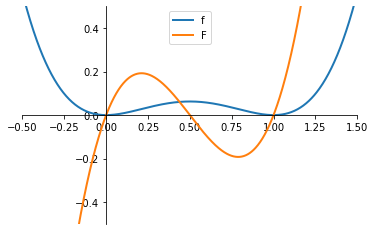

In [3]:
x = linspace(-0.5, 1.5, 1025)
ax = figure().add_subplot(1, 1, 1)
# Move left y-axis and bottim x-axis to centre, passing through (0,0)
ax.spines['left'].set_position('zero')
ax.spines['bottom'].set_position('zero')
# Eliminate upper and right axes
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
_ = plot(x, f(x), 'C0', linewidth=2)
_ = plot(x, F(x), 'C1', linewidth=2)  # '#FF8100'
xlim(-0.5, 1.5)
ylim(-0.5, 0.5)
_ = legend(("f", "F"), loc='upper center')

2. Write a function that takes in input a vector of support points of dimension `ndofs` and the degree `degree` of the polynomial basis, and returns a list of basis functions (piecewise polynomial objects of type `PPoly`) of dimension `ndofs`, representing the interpolatory spline basis of degree `degree`

In [4]:
# Step 1.2

def compute_basis_functions(support_points, degree):
    ndofs = len(support_points)
    basis = []
    
    for i in range(ndofs):
        c = support_points*0
        c[i] = 1
        bi = PPoly.from_spline(splrep(support_points, c, k=degree))
        basis.append(bi)

    # return basis
    return basis

3. Write a function that, given a piecewise polynomial object of type `PPoly` and a number `n_gauss_quadrature_points`, computes the vector of global_quadrature_points and global_quadrature_weights, that contains replicas of a Gauss quadrature formula with `n_gauss_quadrature_points` on each of the intervals defined by `unique(PPoly.x)`

In [5]:
# Step 1.3

def compute_global_quadrature(basis, n_gauss_quadrature_points):
    '''
    Create a Gauss quadrature formula with n_gauss_quadrature_points, extract the intervals from basis (i.e.,
    unique(basis.x)), and create len(x)-1 shifted and scaled Gauss quadrature formulas that can be used to
    integrate on each interval. Put all of these together, and return the result
    '''
    
    # Make sure every interval border is taken only once
    intervals = unique(basis[0].x)

    # and make sure we can integrate exactly the product of two basis functions
    # Gauss-Legendre quadrature. Computes the sample points and weights for Gauss-Legendre quadrature. These sample points and weights will correctly integrate polynomials of degree 2*deg - 1 or less over the interval [-1, 1] with the weight function f(x) = 1.
    qp, w = numpy.polynomial.legendre.leggauss(n_gauss_quadrature_points)

    # Rescale the points and weights to work in [0,1] instead of in [-1,1]
    qp = (qp+1)/2  # quadrature points
    w /= 2         # weights

    # Now replicate these points and weights in all the intervals
    h = diff(intervals)
    Q = array([intervals[i]+h[i]*qp for i in range(len(h))]).reshape((-1,)) # The new shape should be compatible with the original shape. If an integer, then the result will be a 1-D array of that length. One shape dimension can be -1. In this case, the value is inferred from the length of the array and remaining dimensions.
    W = array([w*h[i] for i in range(len(h))]).reshape((-1,))
    
    # return gloabl_quadrature, global_weights
    return Q, W

4. Write a function that, given the basis and the quadrature points and weights, returns the two matrices $M$ and $K$.

In [6]:
# Step 1.4

def compute_system_matrices(basis, gloabl_quadrature, global_weights):
    '''
    Compute the matrices M_ij = (v_i, v_j) and K_ij = (v_i', v_j')
    '''
    
    m = len(basis)
    dbasis = []
    for i in range(m):
        dbasis.append(basis[i].derivative(1))
    Bq = array([basis[i](gloabl_quadrature) for i in range(m)]).T
    dBq = array([dbasis[i](gloabl_quadrature) for i in range(m)]).T
    
    M = einsum('qi, q, qj', Bq, global_weights, Bq)  # Evaluates the Einstein summation convention on the operands.
    K = einsum('qi, q, qj', dBq, global_weights, dBq)
    #rhs = einsum('qi, q, q', Bq, global_weights, gloabl_quadrature)
    
    return M, K#, rhs

-----

**Step 2**

Solve the Allen-Cahan equation on the interval $[0,1]$, from time $t=0$ and time $t=1$, given a time step `dt`, a number of degrees of freedom `ndofs`, and a polynomial degree `k`.

1. Write a function that takes the initial value of $\eta_0$ as a function, eps, dt, ndofs, and degree, and returns a matrix of dimension `(int(T/dt), ndofs)`  containing all the coefficients $\eta_k^i$ representing the solution, and the set of basis functions used to compute the solution

    The equation describes the time evolution of a scalar-valued state variable $\eta$  on a domain $\Omega=[0,1]$  during the time interval $[0,1]$ (we have that $T=1$), and is given (in one dimension) by:

    $$
    \begin{cases}
    \frac{\partial \eta}{\partial t} - \varepsilon^2 \eta'' + f'(\eta) = 0, \\
    \eta'(0, t) = \eta'(1, t) = 0,\\
    \eta(x,0) = \eta_0(x)
    \end{cases}
    $$

In [7]:
# Step 2.1

def solve_allen_cahan(eta_0_function, eps, dt, ndofs, degree):
    # put together all the above functions, loop over time, and produce the result matrix eta,
    # containing the solution at all points
    
    n_steps = int(1/dt) + 1   # the number of time steps
    q = linspace(0,1, ndofs)  # the spatial points
    
    basis = compute_basis_functions(support_points = q, degree = degree)
    Q, W = compute_global_quadrature(basis, n_gauss_quadrature_points = degree)
    M, K = compute_system_matrices(basis, gloabl_quadrature = Q, global_weights = W)
    A = M + dt * eps**2 * K
    
    eta = zeros((n_steps, ndofs))
    eta[0] = eta_0_function(q)   # I discretize my function on the spatial points I have
    b = M.dot(eta[0] - dt*F(eta[0]))
    for i in range(1, n_steps):
        eta[i] = linalg.solve(A, b)
        b = M.dot(eta[i] - dt*F(eta[i]))
    
    return eta, basis

2. Write a function that takes all the solutions `eta`, the basis functions, a stride number `s`, and a resolution `res`, and plots on a single plot the solutions $\eta_0$, $\eta_s$, $\eta_{2s}$, computed on `res` equispaced points between zero and one.

In [8]:
# Step 2.2

def plot_solution(eta, basis, stride, resolution, initial = True):
    # plot eta[::stride], on x = linspace(0,1,resolution)
    x = linspace(0,1,resolution)
    
    B = zeros((resolution, len(basis)))
    for i in range(len(basis)):
        B[:,i] = basis[i](x)
    
    l = shape(eta)[0]
    if (stride < 0):  # if I want to print only the final solution at t=1
        prange = [stride]
    else:
        prange = range(0, l, stride)
    if not initial:
        prange = prange[1:]
    for i in prange:
        # plot(unique(basis[0].x), eta[0]) # error in the length of the basis if deg>1
        plot(x, B.dot(eta[i]))
    legend([f"eta_{z}, t={z/(shape(eta)[0]-1)}" for z in prange])
    xlabel("$x$")
    ylabel("$\eta(x,t)$")

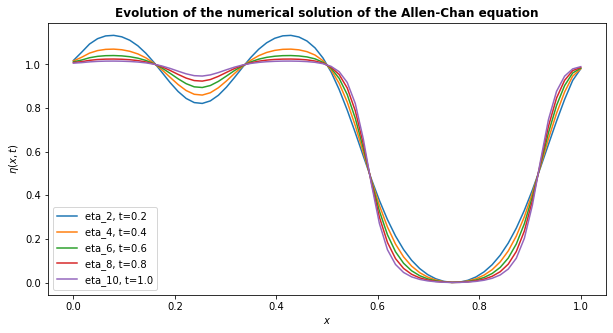

In [9]:
eta, basis = solve_allen_cahan(lambda x: sin(2 * pi * x) + 1, 0.01, 0.1, 128, 3)
figure(figsize=(10,5))
title('Evolution of the numerical solution of the Allen-Chan equation', weight='bold')
plot_solution(eta, basis, stride = 2, resolution = 64, initial = False)

------

**Step 3**

Solve the problem for all combinations of

1. eps = [.01, .001]

2. ndofs = [16, 32, 64, 128]

3. degree = [1, 2, 3]

3. dt = [.25, .125, .0625, .03125, .015625]

with $\eta_0 = \sin(2 \pi x)+1$.

Plot the final solution at $t=1$ in all cases. What do you observe? What happens when you increase ndofs and keep dt constant? 

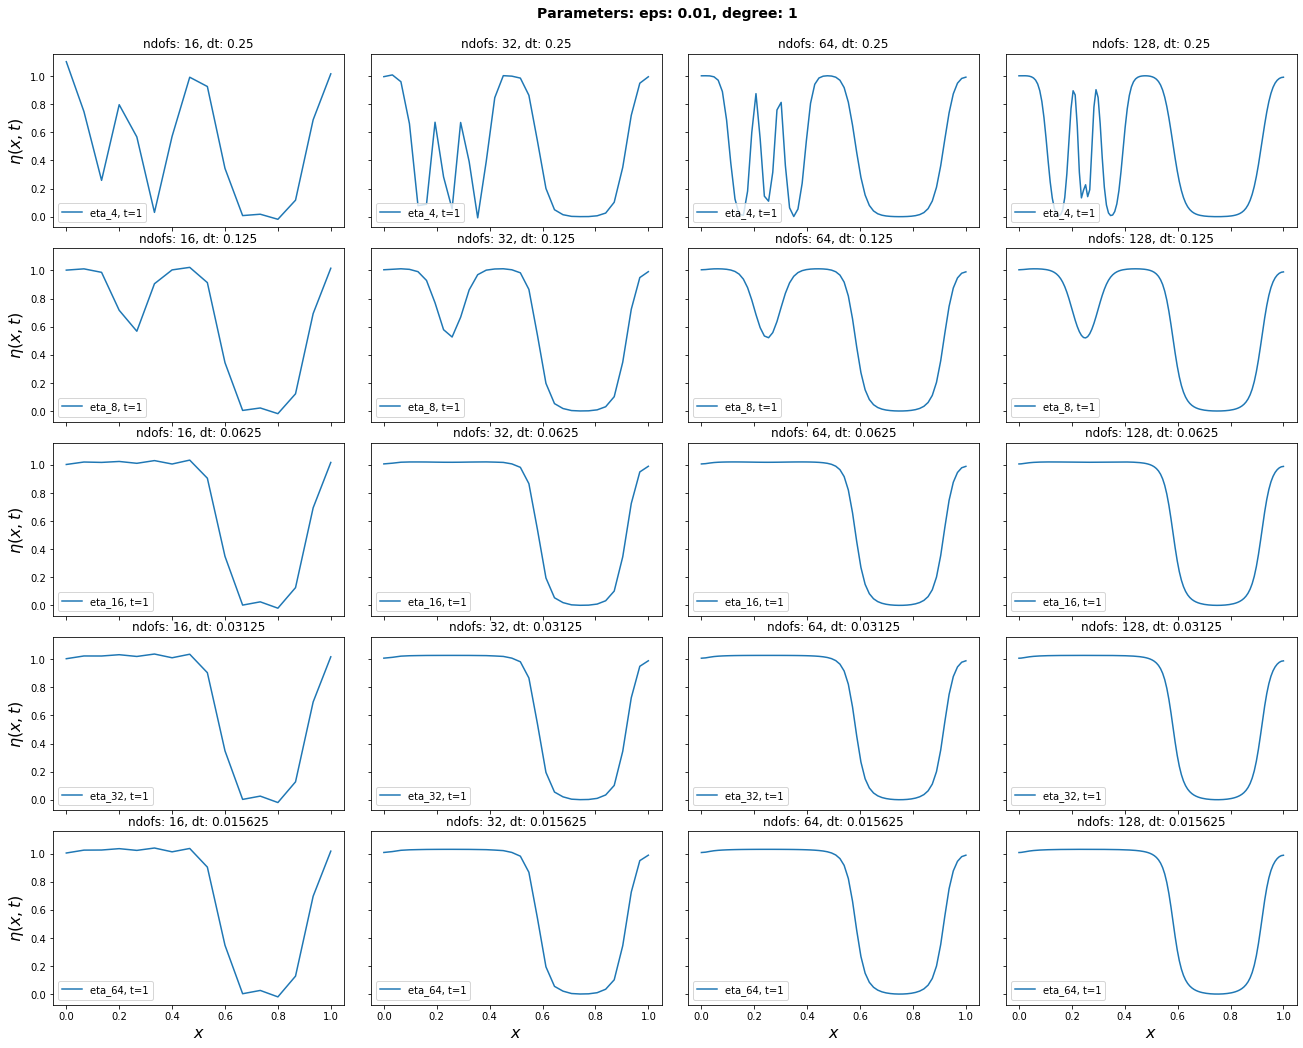

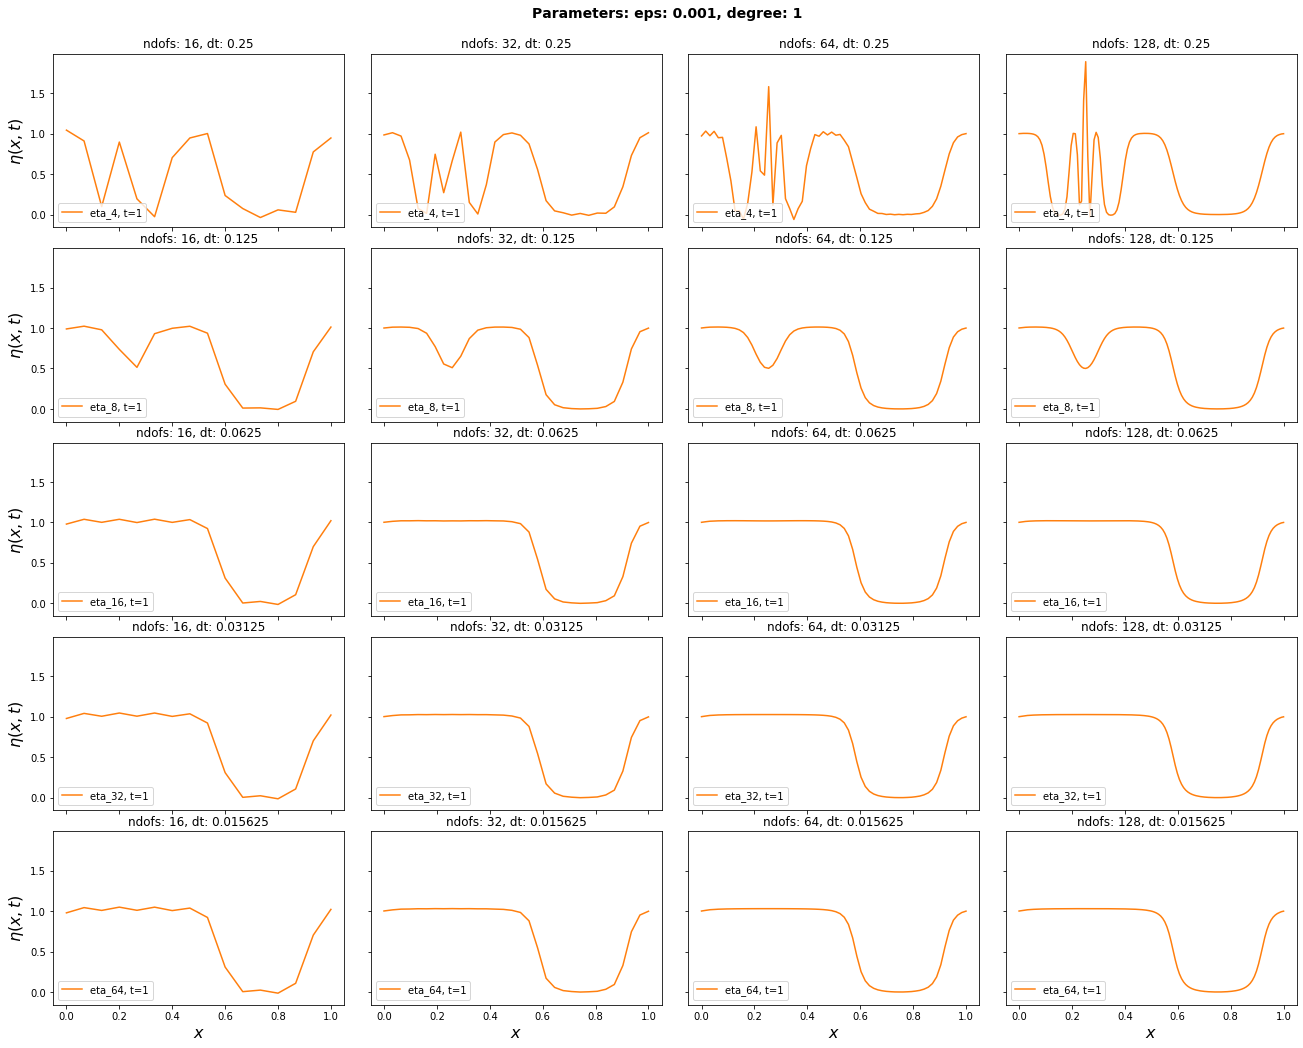

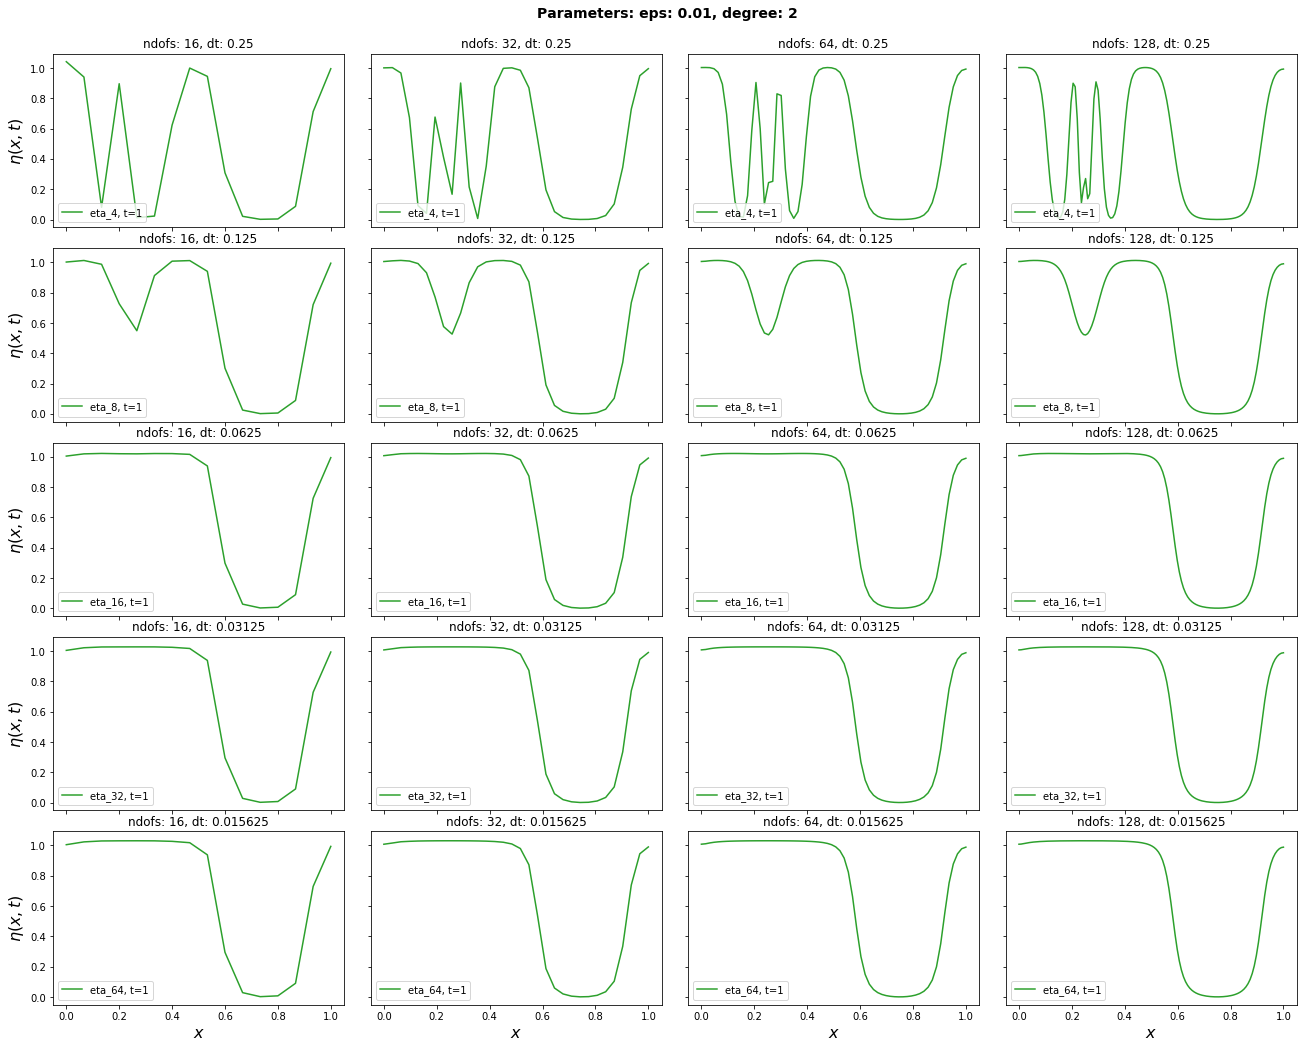

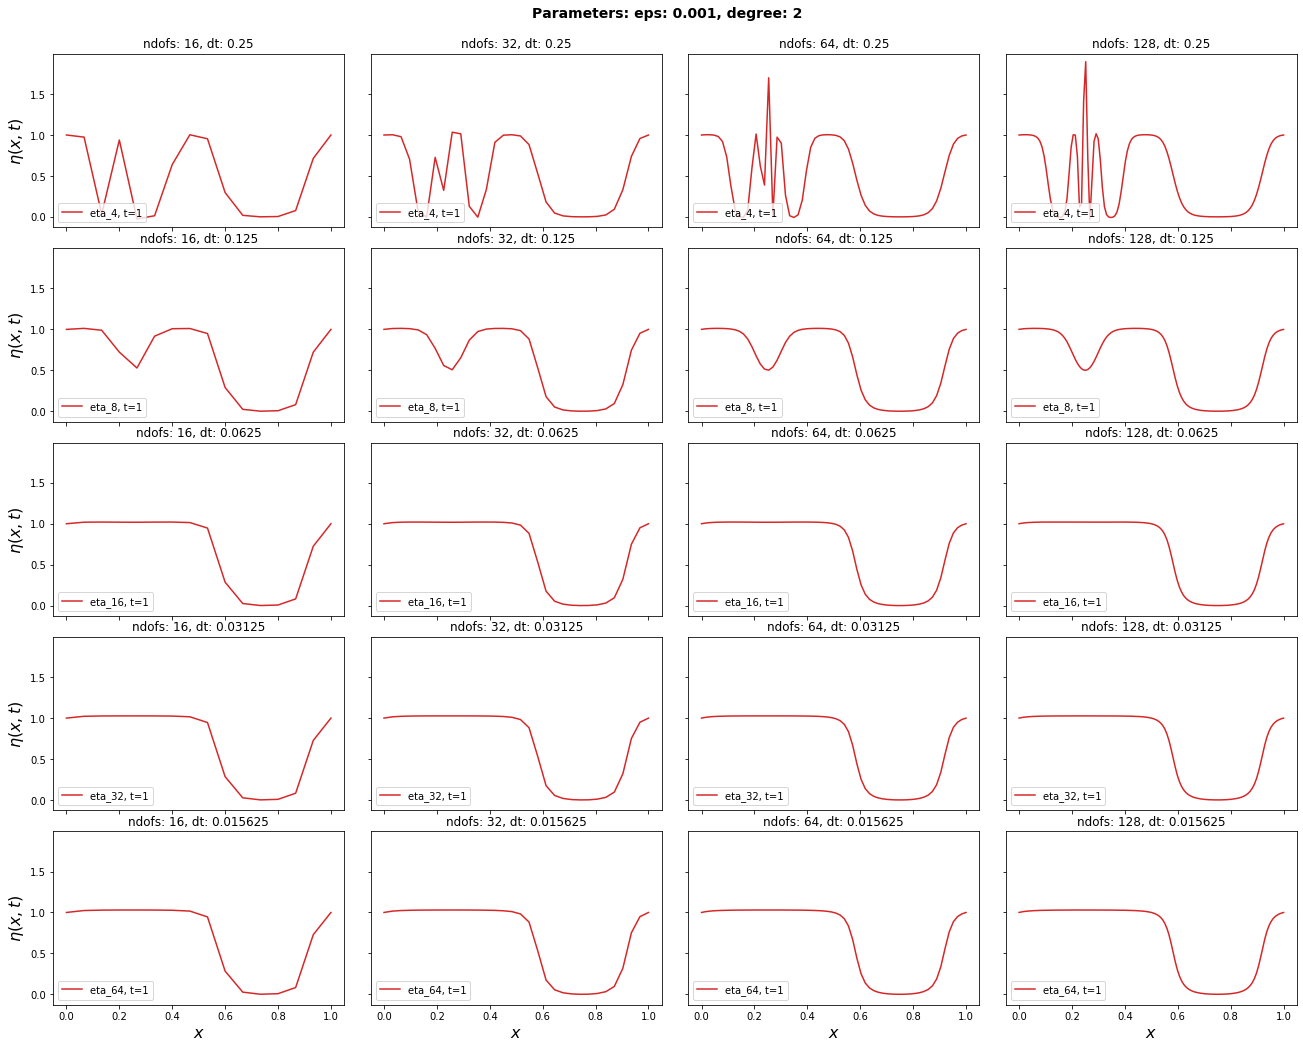

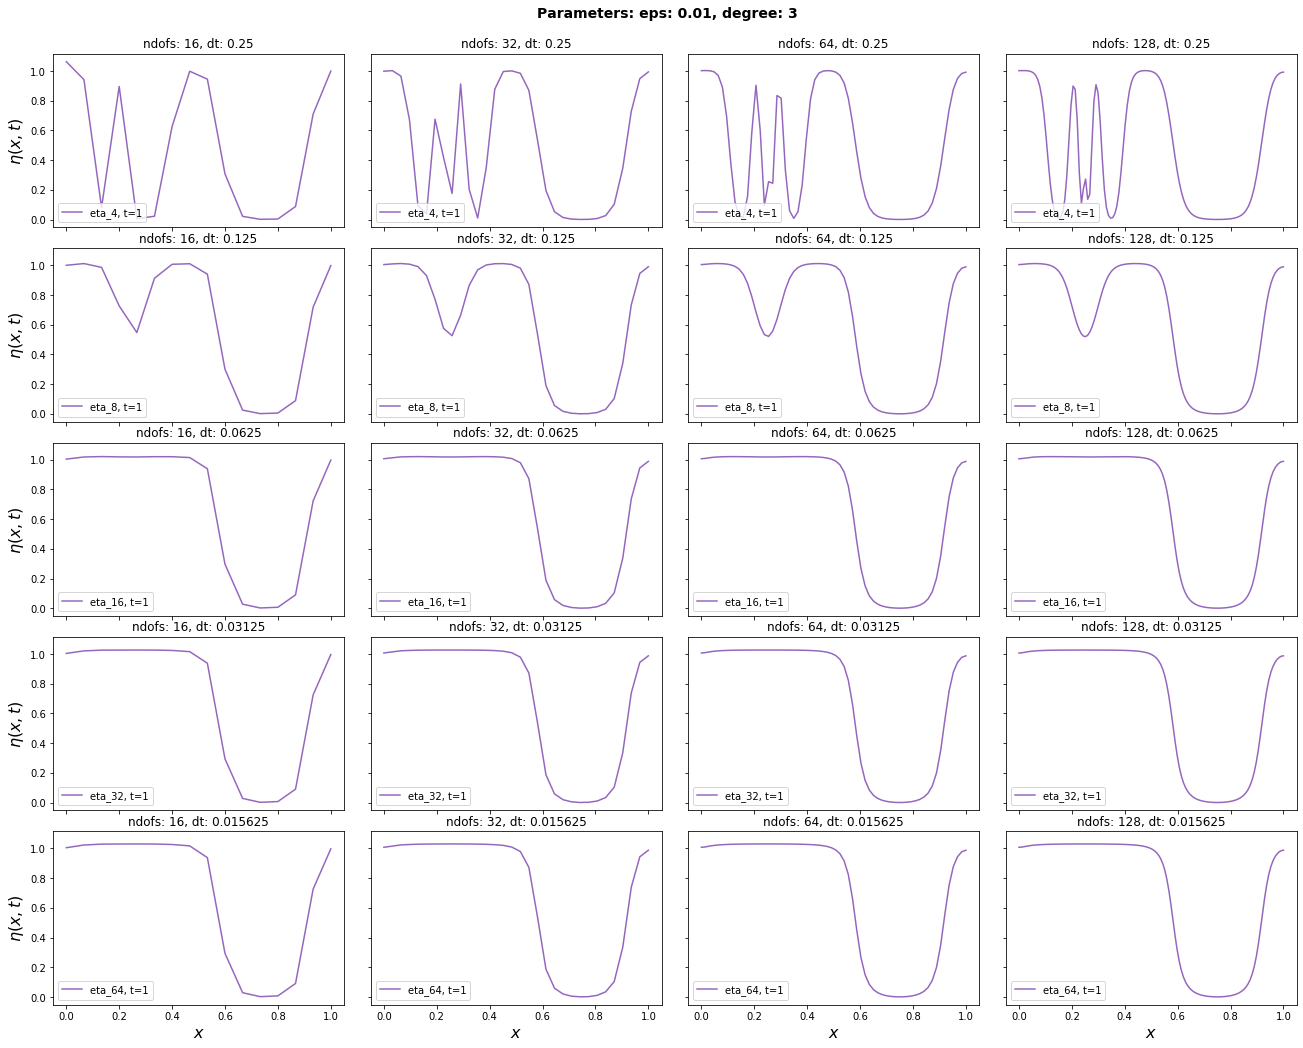

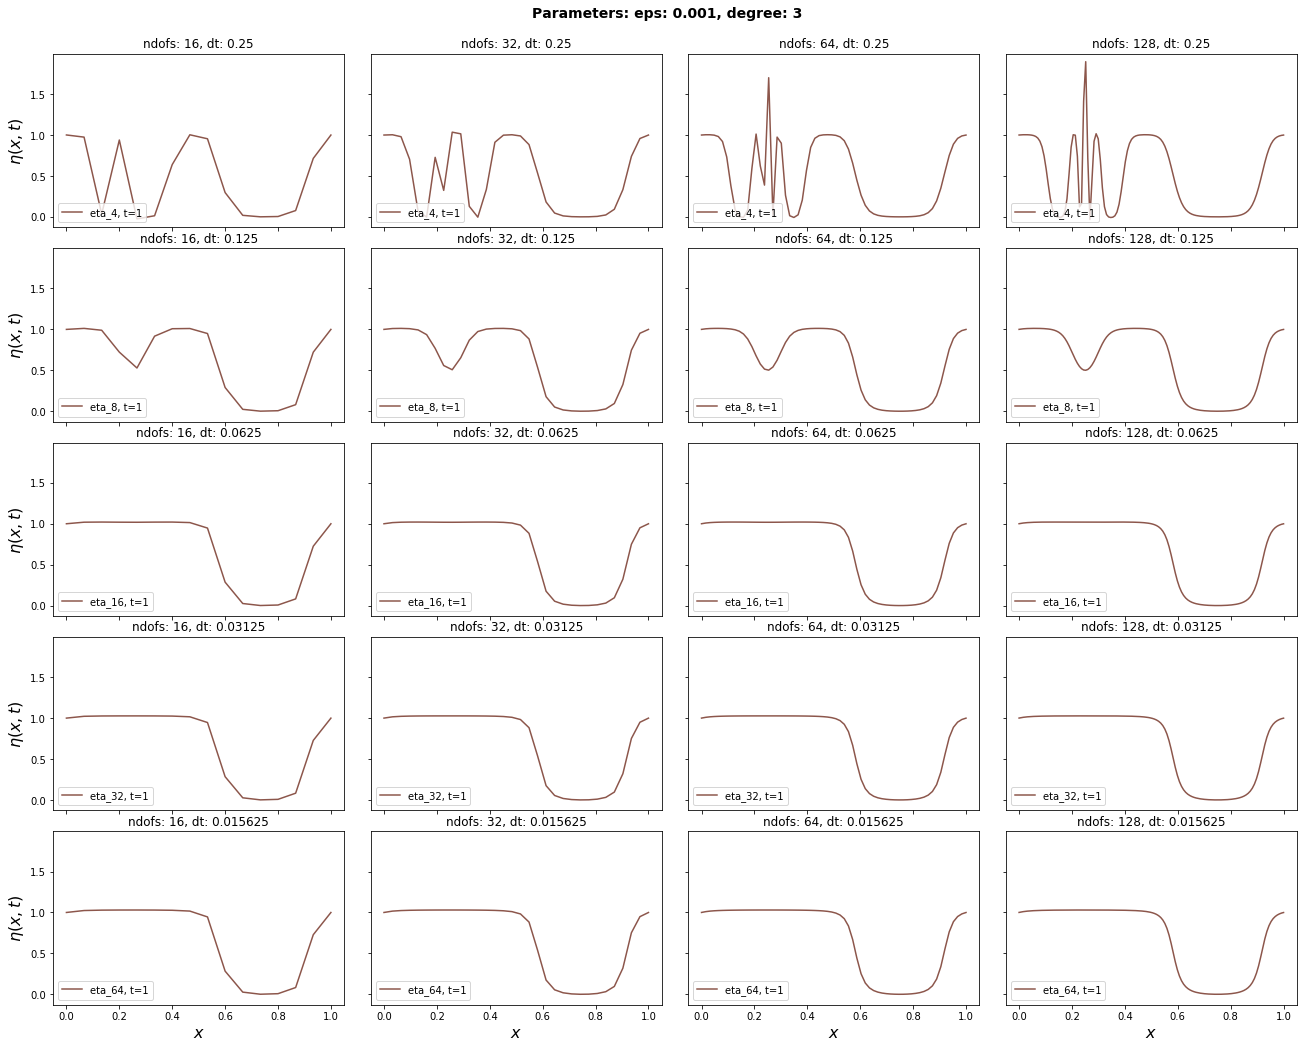

In [10]:
def eta_0_function(x):
    return sin(2 * pi * x) + 1

degree = [1, 2, 3]
eps = [0.01, 0.001]
ndofs = [16, 32, 64, 128]
dt = [.25, .125, .0625, .03125, .015625]

c = -1  # to change the color of the plots
for l in range(len(degree)):
    for k in range(0, len(eps)):
        c += 1
        fig, axs = plt.subplots(len(dt), len(ndofs), figsize=(18, 15), sharex=True, sharey=True)
        fig.tight_layout(rect=[0, 0.03, 1, 0.95])   # [left, bottom, right, top] in normalized (0, 1) figure coordinates
        fig.suptitle(f"Parameters: eps: {eps[k]}, degree: {degree[l]}", fontsize=14, weight='bold')
        for i in range(len(dt)):
            for j in range(len(ndofs)):
                eta, basis = solve_allen_cahan(eta_0_function, eps[k], dt[i], ndofs[j], degree[l])
                #plot_solution(eta, basis, stride = -1, resolution = ndofs[j])
                axs[i, j].plot(linspace(0, 1, ndofs[j]), eta[-1], f"C{c}", label = f"eta_{int(1/dt[i])}, t=1")
                axs[i, j].set_title(f"ndofs: {ndofs[j]}, dt: {dt[i]}")
                axs[i, j].legend(loc='lower left')
                if (i == len(dt)-1):
                    axs[i, j].set_xlabel("$x$", fontsize=16)
                if (j == 0):
                    axs[i, j].set_ylabel("$\eta(x,t)$", fontsize=16)
#subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=0.9, wspace=0.2, hspace=0.5)

We can see that if `dt` is big, so if we have few time points, the algorithm doesn't convrege to the right solution. In fact, if $dt < 0.0625$, the algorithm doesn't reach the solution for any number of `ndofs`, `degree` and `eps`.

If we increase ndofs and keep dt constant, we can observe that the solution becomes much more smooth. This is natural since incrementing `ndofs` we increment the number of points on which we divide our spatial interval $[0,1]$, so we increment the number of basis functions we use, giving a better approximation of our function.

So we can conclude that reducing `dt` makes the solution converge, while incrementing `ndofs` makes the solution more smooth.

------

**Step 4**

Instead of solving the problem explicitly, solve it implicitly, by using backward euler method also for the non linear term. This requires the solution of a Nonlinear problem at every step. Use scipy and numpy methods to solve the non linear iteration.

We'll use the Backward Euler method to deal with the term $\frac{\partial \eta}{\partial t}$ in

$$
\frac{\partial \eta}{\partial t} - \varepsilon^2 \eta'' + f'(\eta) = 0
$$

We split the interval $[0,T]$ in `n_steps` intervals, of dimension `dt = T/n_steps`. Given the solution at time `t[k] = k*dt`, it i possible to compute the next solution at time `t[k+1]` as

$$
\frac{\eta_{k} - \eta_{k-1}}{\Delta t} = \varepsilon^2 \eta_k'' - f'(\eta_k) \; \Longrightarrow \; \eta_{k} = \eta_{k-1} + \Delta t\varepsilon^2 \eta_k'' - \Delta tf'(\eta_k)
$$

and to adapt it to the previous notation we rewrite it as

$$
\eta_{k+1} - \Delta t\varepsilon^2 \eta_{k+1}'' = \eta_k - \Delta tf'(\eta_{k+1})
$$

As before, given a set of basis functions $v_i$ and representing $\eta = \eta^j v_j$, we can solve the problem using finite elements by computing


$$
\big((v_i, v_j) + \Delta t \varepsilon^2  (v_i', v_j')\big) \eta^j_{k+1} = (v_i, v_j) \eta^j_{k} - \Delta t (v_i, f'(\eta_{k+1}^j))
$$

(here we don't need to change the spatial scheme since we already have the term $\eta^j_{k+1}$), so we have the following nonlinear equation:

$$
\big((v_i, v_j) + \Delta t \varepsilon^2  (v_i', v_j')\big) \eta^j_{k+1} - (v_i, v_j) \eta^j_{k} + \Delta t (v_i, f'(\eta_{k+1}^j)) = 0
$$

Let's define the matrix $A$ as

$$
A_{ij} = M_{ij}+ \Delta t \varepsilon^2 K_{ij} = \big((v_i, v_j) + \Delta t \varepsilon^2  (v_i', v_j')\big) 
$$

so we have that the nonlinear equation becomes

$$
A_{ij} \eta^j_{k+1} - M_{ij} \eta_k^j + \Delta t M_{ij} f'(\eta_{k+1}^j) = 0
$$

where we simplified the integration on the right hand side, by computing the integral of the interpolation of $f'(\eta)$.

Definig $G(\eta_{k+1}^j) := A_{ij} \eta^j_{k+1} - M_{ij} \eta_k^j + \Delta t M_{ij} f'(\eta_{k+1}^j)$, at each step we have to resolve $G(\eta_{k+1}^j) = 0$.

I used the method `newton_krylov` of the package `scipy.optimize`, the documentation is at this [link](https://docs.scipy.org/doc/scipy/reference/optimize.nonlin.html).

In [11]:
from scipy.optimize import newton_krylov

def solve_allen_cahan_implicit(eta_0_function, eps, dt, ndofs, degree):
    # put together all the above functions, loop over time, and produce the result matrix eta,
    # containing the solution at all points
    
    n_steps = int(1/dt) + 1   # the number of time steps
    q = linspace(0,1, ndofs)  # the spatial points
    
    basis = compute_basis_functions(support_points = q, degree = degree)
    Q, W = compute_global_quadrature(basis, n_gauss_quadrature_points = degree)
    M, K = compute_system_matrices(basis, gloabl_quadrature = Q, global_weights = W)
    A = M + dt * eps**2 * K
    
    eta = zeros((n_steps, ndofs))
    eta[0] = eta_0_function(q)   # I discretize my function on the spatial points I have
    for i in range(1, n_steps):
        eta[i] = newton_krylov(lambda x: A.dot(x) - M.dot(eta[i-1]) + dt*M.dot(F(x)), eta[i-1])
    
    return eta, basis

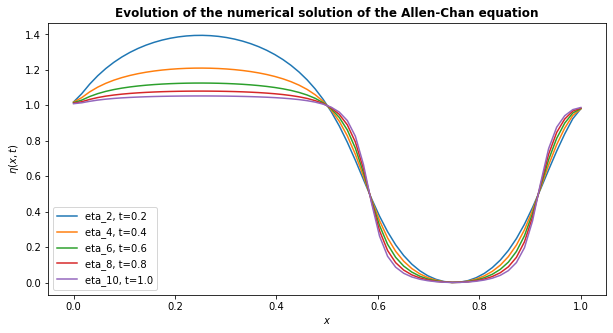

In [12]:
eta, basis = solve_allen_cahan_implicit(eta_0_function, 0.01, 0.1, 128, 3)
figure(figsize=(10,5))
title('Evolution of the numerical solution of the Allen-Chan equation', weight='bold')
plot_solution(eta, basis, stride = 2, resolution = 64, initial = False)

Comparing this plot with the one after Step 2, we can see that the solution with Backward Euler converges faster. Let's compare the two methods properly:

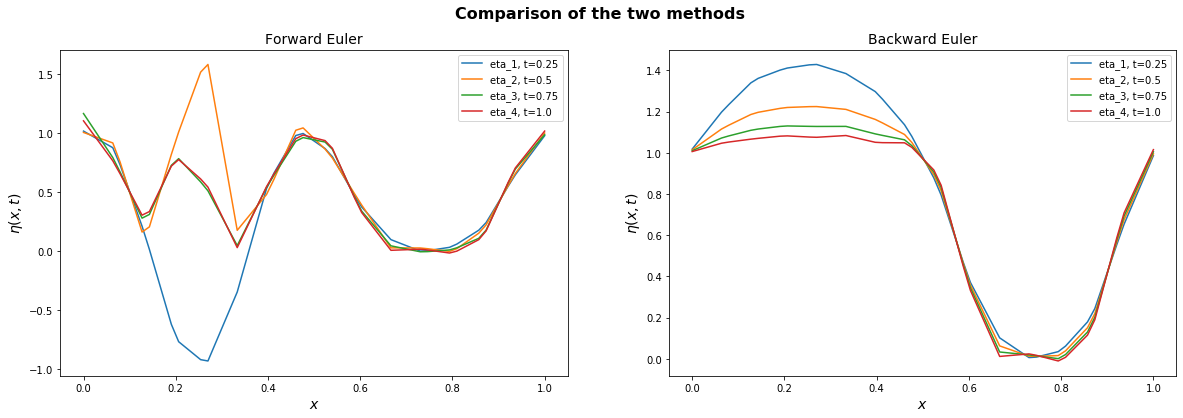

In [13]:
degree = 1
eps = 0.01
ndofs = 16
dt = 0.25
      
fig, axs = plt.subplots(1, 2, figsize=(20, 6), sharey=True)
fig.suptitle(f"Comparison of the two methods", fontsize=16, weight='bold')

eta, basis = solve_allen_cahan(eta_0_function, eps, dt, ndofs, degree)
subplot(1, 2, 1)
plot_solution(eta, basis, stride = 1, resolution = 64, initial = False)
title(f"Forward Euler", fontsize=14)
xlabel("$x$", fontsize=14)
ylabel("$\eta(x,t)$", fontsize=14)

eta, basis = solve_allen_cahan_implicit(eta_0_function, eps, dt, ndofs, degree)
subplot(1, 2, 2)
plot_solution(eta, basis, stride = 1, resolution = 64, initial = False)
title(f"Backward Euler", fontsize=14)
xlabel("$x$", fontsize=14)
_=ylabel("$\eta(x,t)$", fontsize=14)

We can clearly see that for a big number for `dt` the algorithm that uses forward Euler for the first time derivative term doesn't converge (as we can also see from the grid of graphs above), while the algorithm with backward Euler on the first time derivative term converges much better: even if it's not perfect we can recognise the shape of the right solution (simply incrementing `ndofs` will sharpen the solution). So we can conclude that the backward Euler algorithm takes less steps to converge to the right solution. This is because the backward Euler algorithm is unconditionally absolutely stable, while the forward Euler is conditionally absolutely stable: if the time step `dt` is not limited the method diverges.